<a href="https://colab.research.google.com/github/pranath/breast_cancer_prediction/blob/master/breast_cancer_prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast cancer prediction

## 1 Introduction

In this project I will look at a dataset of patient data relating to breast cancer, which is available on Kaggle as the [Wisconsin Breast Cancer dataset](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

The dataset features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image in the 3-dimensional space is that described in: K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34.

The dataset was released in November 1995 and the original source can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). 

An example of images of cells that this data comes from of both malignant and benign tumors can be seen below.

![title](img/bc_cells.png)

Traditionally one of the main ways you could diagnose if a tumor is malignant or benign is to take a biopsy of a breast mass and then visually examine cell nuclei under a microscope. A trained specialist can then decide if there is cancer or not.

We can see here in the example above that the image on the left belongs to a patient who was diagnosed with a benign tumor, and the image on the right belong to a patient who was diagnosed with a malignant tumor.

### 1.1 Features

The dataset we have consists of 32 features which relate to these types of images & cells and are the following:

- ID number 
- Diagnosis (M = malignant, B = benign) 

Features 3-32 are ten real-valued features are computed for each cell nucleus: 

- a) radius (mean of distances from center to points on the perimeter) 
- b) texture (standard deviation of gray-scale values) 
- c) perimeter 
- d) area 
- e) smoothness (local variation in radius lengths) 
- f) compactness (perimeter^2 / area - 1.0) 
- g) concavity (severity of concave portions of the contour) 
- h) concave points (number of concave portions of the contour) 
- i) symmetry 
- j) fractal dimension ("coastline approximation" - 1)

The mean, standard error (se) and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

### 1.2 Further details

We can see from the image examples that it is visually possible to distinguish between malignant and benign tumor cells. It is hoped that the data derived from these images of the cells is able to capture the differences between these types of cells.

In this project, I will aim to develop a machine learning model that will aim to predict Malignant tumors with the highest accuracy.


## 2 Import libraries

Let us first import the libraries we will need for analysis and developing our model.

In [131]:
# Import libraries 
import numpy as np
from numpy import array
from numpy import mean
from numpy import var
from numpy import mean
from numpy import median
from numpy import percentile
from numpy import std
from numpy.random import seed
from numpy.random import rand
from numpy.random import randint
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot 
from statsmodels.stats.power import TTestIndPower
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D  
import sklearn
from sklearn.manifold import TSNE
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from xgboost import XGBClassifier
import seaborn as sns
import time
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import mannwhitneyu
from scipy.stats import boxcox
from scipy.stats import ttest_ind
from umap import UMAP
import plotly.express as px



from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Datasets/"
file = root_dir + "data.csv"

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/gdrive


## 3 Initial data exploration

We will now take an initial look at the dataset, its values and structure.

In [132]:
# Load the Census dataset
bcancer_df = pd.read_csv(file)

In [133]:
# For reproducability of the results
np.random.seed(42)
# Observe first few rows
bcancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Ok we can see there are quite a range of continous values for each of the features. Also note something odd, the final column is called 'Unnamed: 32' and is full of nan's - it's not mentioned in the dataset description and looks like some kind of format error in the dataset csv. Let's note that for later in our cleaning phase.

Lets compute some key stats for each of the features to get a feel for them.

In [134]:
# Compute key stats for each feature
bcancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


Ok quite a bit of variation in the scale and range of values (note also very variable std. dev.) we will need scaling of features later before we feed the data to our model.

Lets now check for completeness of data, which according to the dataset description should not have any missing values.

In [135]:
# Check for nans
bcancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Ok all looks complete (bar our 'Unnamed: 32' column which we will drop later in our cleaning phase).

Let's now check the proportions of the dataset between benign & malignant target classes.

In [136]:
bcancer_df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

That's in line with our expectations from the dataset description, however it is encoded as a string/categorical value and we will need to make that numeric before feeding into our ML model.

## 4 Clean data

So we have just a couple of cleaning steps identified previously, which are to convert the diagnosis field into numeric values and to drop the id and 'Unnamed: 32' columns.

In [137]:
# Encode the 'diagnosis' feature to numerical values
bcancer_clean_df = bcancer_df.replace(['B', 'M'], [0, 1])

In [138]:
# Remove last column 
bcancer_clean_df = bcancer_clean_df.drop(bcancer_df.columns[len(bcancer_df.columns)-1], axis=1)
# Remove id column
bcancer_clean_df = bcancer_clean_df.drop(['id'], axis=1)
# Show first few rows
bcancer_clean_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 5 Further data exploration

Ok now we have cleaned up our dataset, we are in a better position to look more closely at it.

### 5.1 Compare distribution of values for each feature between benign & malignent tumor sub-groups

Let's do a univariate exploration of each of the numerical features, but by dividing the dataset into sub-groups for 'diagnosis' i.e. malignant and benign sub groups, and compare the distributions for each sub groups to see what patterns there are.

In [139]:
# Split dataset into those with malignent and those with benign tumors
malignent_df = bcancer_clean_df[bcancer_clean_df['diagnosis']==1]
benign_df = bcancer_clean_df[bcancer_clean_df['diagnosis']==0]

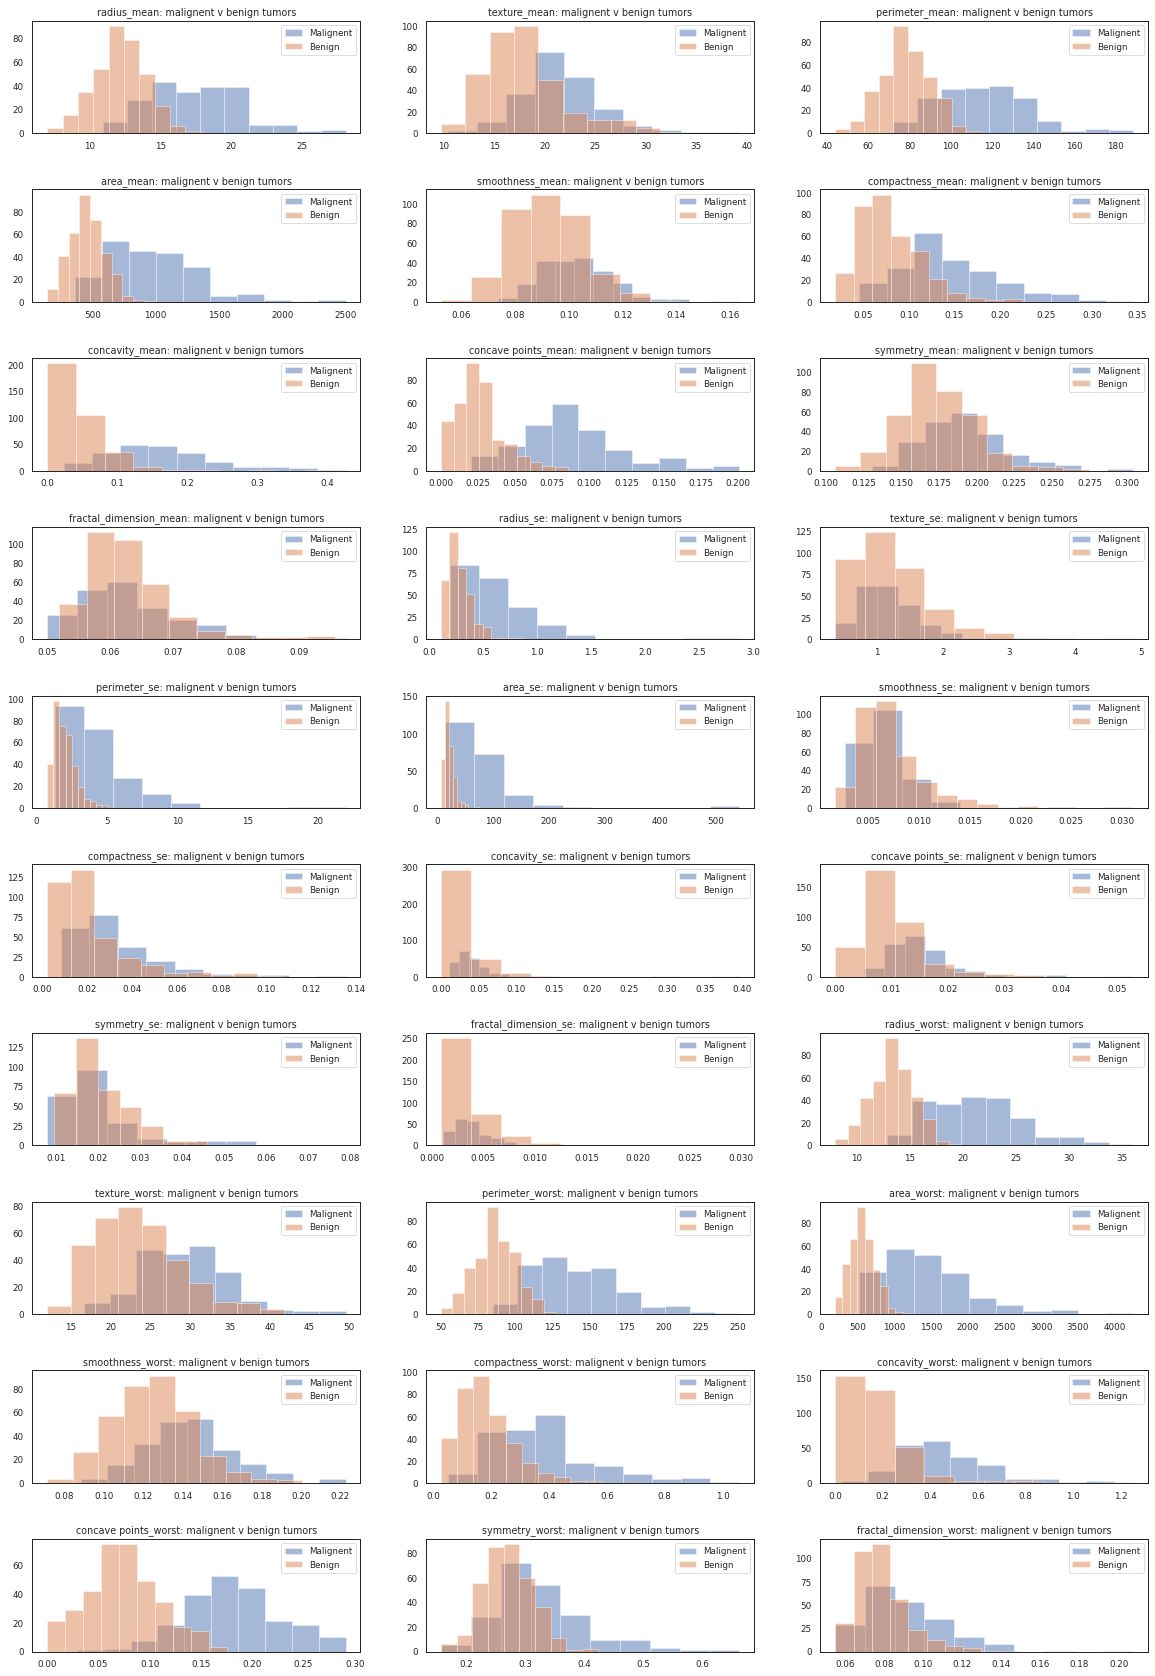

In [140]:
# Function for plotting feature distributions to compare benign & malignent sub-groups
def compare_features_benign_malignent(features, malignent_df, benign_df, rows, cols, figx, figy):
    
    # Define constants
    bins = 10
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figx, figy))
    fig.subplots_adjust(hspace=0.5)
    # For each axes & feature
    for index, (ax, feature) in enumerate(zip(axes.flatten(), features)):
        
        ax.hist(malignent_df[feature], bins, alpha=0.5, label='Malignent')
        ax.hist(benign_df[feature], bins, alpha=0.5, label='Benign')
        ax.legend(loc='upper right')
        ax.set_title(feature + ": malignent v benign tumors")        

# Get feature names (remove first element diagnosis which is target feature)
features = bcancer_clean_df.columns
features = features[1:]
# Plot feature distributions to compare benign & malignent sub-groups
compare_features_benign_malignent(features, malignent_df, benign_df, 10, 3, 20, 30)

So we can see several interesting aspects to the data from these comparitive histograms.

Firstly, there are some features that seem to have a significant difference between the distributions of malignant v benign, these are:

- perimeter_mean
- area_mean
- concave points_mean
- radius_worst
- perimeter_worst
- concave points_worst

These might proove useful features for our model to help better predict & distinguish between and predict malignant v benign tumors. 

### 5.2 Check normality of key distributions

Let us just check the normality of one of the distributions that appears to be more normal and one of the more skewed distributions.

In [141]:
features = ['area_mean', 'symmetry_mean']

for feature_name in features:

  print(' ')
  print('Testing ' + feature_name + ' normality')
  print(' ')

  print('Benign subgroup')
  print(' ')
  feature = benign_df[feature_name]
  print('shapiro-wilk test')
  # normality test
  stat, p = shapiro(feature) 
  print('Statistics=%.3f, p=%.3f' % (stat, p)) 
  # interpret
  alpha = 0.05
  if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)') 
  else:
    print('Sample does not look Gaussian (reject H0)')

  print('dagostino and pearsons test')
  # normality test
  stat, p = normaltest(feature) 
  print('Statistics=%.3f, p=%.3f' % (stat, p)) 
  if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)') 
  else:
    print('Sample does not look Gaussian (reject H0)')


  print('anderson test')
  result = anderson(feature)
  print('Statistic: %.3f' % result.statistic) 
  p=0
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
      print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv)) 
    else:
      print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

  print(' ')
  print('Malignant subgroup')
  print(' ')
  feature = malignent_df[feature_name]
  print('shapiro-wilk test')
  # normality test
  stat, p = shapiro(feature) 
  print('Statistics=%.3f, p=%.3f' % (stat, p)) 
  # interpret
  alpha = 0.05
  if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)') 
  else:
    print('Sample does not look Gaussian (reject H0)')

  print('dagostino and pearsons test')
  # normality test
  stat, p = normaltest(feature) 
  print('Statistics=%.3f, p=%.3f' % (stat, p)) 
  if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)') 
  else:
    print('Sample does not look Gaussian (reject H0)')


  print('anderson test')
  result = anderson(feature)
  print('Statistic: %.3f' % result.statistic) 
  p=0
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
      print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv)) 
    else:
      print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

 
Testing area_mean normality
 
Benign subgroup
 
shapiro-wilk test
Statistics=0.991, p=0.023
Sample does not look Gaussian (reject H0)
dagostino and pearsons test
Statistics=8.255, p=0.016
Sample does not look Gaussian (reject H0)
anderson test
Statistic: 0.460
15.000: 0.570, data looks normal (fail to reject H0)
10.000: 0.649, data looks normal (fail to reject H0)
5.000: 0.778, data looks normal (fail to reject H0)
2.500: 0.908, data looks normal (fail to reject H0)
1.000: 1.080, data looks normal (fail to reject H0)
 
Malignant subgroup
 
shapiro-wilk test
Statistics=0.933, p=0.000
Sample does not look Gaussian (reject H0)
dagostino and pearsons test
Statistics=46.927, p=0.000
Sample does not look Gaussian (reject H0)
anderson test
Statistic: 2.267
15.000: 0.566, data does not look normal (reject H0)
10.000: 0.644, data does not look normal (reject H0)
5.000: 0.773, data does not look normal (reject H0)
2.500: 0.901, data does not look normal (reject H0)
1.000: 1.072, data does not 

 
Testing area_mean normality with QQ Plot
 
Benign subgroup
 


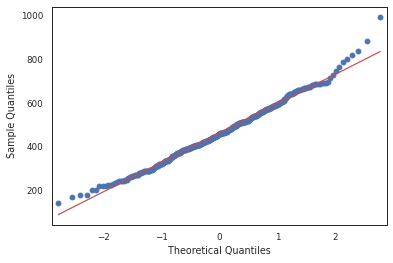

 
Malignant subgroup
 


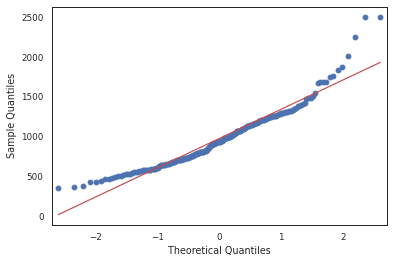

 
Testing symmetry_mean normality with QQ Plot
 
Benign subgroup
 


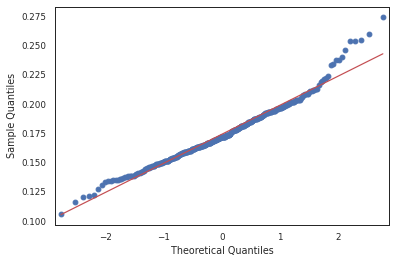

 
Malignant subgroup
 


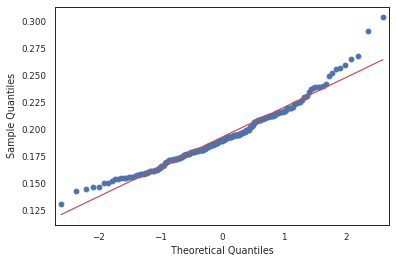

In [142]:
features = ['area_mean', 'symmetry_mean']

for feature_name in features:

  print(' ')
  print('Testing ' + feature_name + ' normality with QQ Plot')
  print(' ')

  print('Benign subgroup')
  print(' ')
  feature = benign_df[feature_name]
  # q-q plot
  qqplot(feature, line='s')
  plt.show()

  print(' ')
  print('Malignant subgroup')
  print(' ')
  feature = malignent_df[feature_name]
  # q-q plot
  qqplot(feature, line='s')
  plt.show()

So the normality tests for both the more symmetrical radius_mean and symmetry_mean both fail. However we will still attempt to log-transform the more skewed features to assist with better modelling later. 

### 5.3 Test log transformation of skewed distributions for normality

Let is see for now how well we can transform one of the skewed distributions such as radius_se.

Malignant radius_se normality test
Statistics=0.816, p=0.000
Sample does not look Gaussian (reject H0)
Benign radius_se normality test
Statistics=0.903, p=0.000
Sample does not look Gaussian (reject H0)


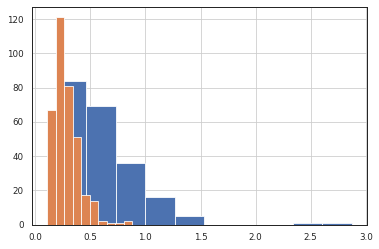

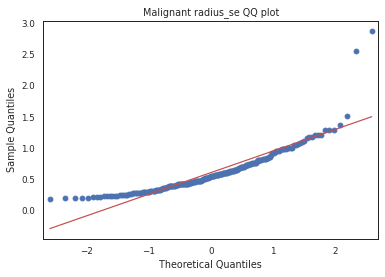

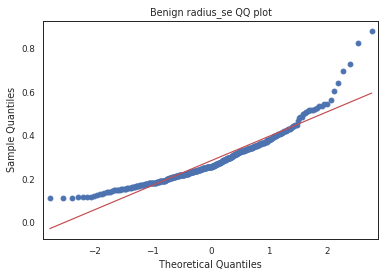

In [143]:
# Plot skewed distributions of radius_se sub-groups
malignent_df['radius_se'].hist()
benign_df['radius_se'].hist()

print('Malignant radius_se normality test')
stat, p = shapiro(malignent_df['radius_se']) 
print('Statistics=%.3f, p=%.3f' % (stat, p)) 
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)') 
else:
  print('Sample does not look Gaussian (reject H0)')

print('Benign radius_se normality test')
stat, p = shapiro(benign_df['radius_se']) 
print('Statistics=%.3f, p=%.3f' % (stat, p)) 
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)') 
else:
  print('Sample does not look Gaussian (reject H0)')

# q-q plot
qqplot(malignent_df['radius_se'], line='s')
plt.title('Malignant radius_se QQ plot')
plt.show()

qqplot(benign_df['radius_se'], line='s')
plt.title('Benign radius_se QQ plot')
plt.show()

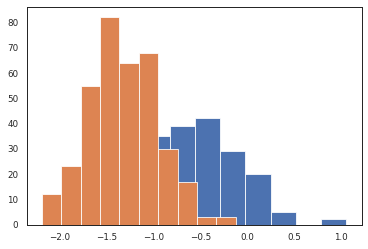

Malignant radius_se normality test
Statistics=0.988, p=0.060
Sample looks Gaussian (fail to reject H0)
Benign radius_se normality test
Statistics=0.995, p=0.285
Sample looks Gaussian (fail to reject H0)


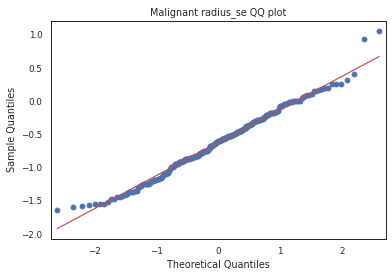

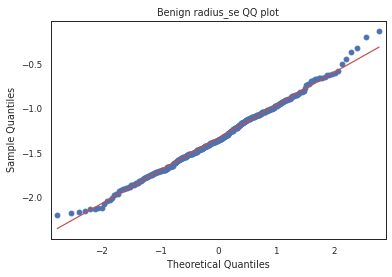

In [144]:
# Apply box-cox transforms to both sub-groups
transformed_radius_se_malignant = boxcox(malignent_df['radius_se'], 0)
transformed_radius_se_benign = boxcox(benign_df['radius_se'], 0)
plt.hist(transformed_radius_se_malignant)
plt.hist(transformed_radius_se_benign)
plt.show()

print('Malignant radius_se normality test')
stat, p = shapiro(transformed_radius_se_malignant) 
print('Statistics=%.3f, p=%.3f' % (stat, p)) 
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)') 
else:
  print('Sample does not look Gaussian (reject H0)')

print('Benign radius_se normality test')
stat, p = shapiro(transformed_radius_se_benign) 
print('Statistics=%.3f, p=%.3f' % (stat, p)) 
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)') 
else:
  print('Sample does not look Gaussian (reject H0)')

# q-q plot
qqplot(transformed_radius_se_malignant, line='s')
plt.title('Malignant radius_se QQ plot')
plt.show()

qqplot(transformed_radius_se_benign, line='s')
plt.title('Benign radius_se QQ plot')
plt.show()

So the box-cox method can be very effective at transforming skewed data to make it normal. This can be useful for applying further parametric statistical tests as well as helping with model training.

### 5.4 Statisitcal test for difference between cancer and non-cancer distributions

Let us check if there is a statisitcally significant difference between the two groups for these features, using a non-parametric test (now that we know the distributions are not normal without transformation). We will compare symmetry_mean as that appears to have very similar distributions with only a small difference - but is it statiscally significant?


In [145]:
# example of the mann-whitney u non-parametric hypothesis test

print('radius_se non-parametric hypothesis test')
print(' ')
# compare samples
stat, p = mannwhitneyu(benign_df['radius_se'], malignent_df['radius_se']) 
print('Statistics=%.3f, p=%.3f' % (stat, p)) 

# interpret    
alpha = 0.05
if p > alpha: 
  print('Same distributions (fail to reject H0)') 
else:
  print('Different distributions (reject H0)')

# Student t test parametric
print(' ')
print('radius_se normalised data parametric hypothesis test')
print(' ')
# compare samples
stat, p = ttest_ind(transformed_radius_se_benign, transformed_radius_se_malignant) 
print('Statistics=%.3f, p=%.3f' % (stat, p)) 

# interpret    
alpha = 0.05
if p > alpha: 
  print('Same distributions (fail to reject H0)') 
else:
  print('Different distributions (reject H0)')

radius_se non-parametric hypothesis test
 
Statistics=9965.000, p=0.000
Different distributions (reject H0)
 
radius_se normalised data parametric hypothesis test
 
Statistics=-19.236, p=0.000
Different distributions (reject H0)


In [146]:
# Calculate effect size, assume normality here and use Cohen's d

# function to calculate cohen's d for independent samples 
def cohend(d1, d2):
  # calculate the size of samples
  n1, n2 = len(d1), len(d2)
  # calculate the variance of the samples
  s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
  # calculate the pooled standard deviation
  s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
  # calculate the means of the samples
  u1, u2 = mean(d1), mean(d2)
  # calculate the effect size
  return (u1 - u2) / s

print(' ')
print('Effect size for normalised radius_se difference between malignant & benign groups')
print(' ')
# calculate cohen's d
d = cohend(transformed_radius_se_malignant, transformed_radius_se_benign) 
print('Cohens d: %.3f' % d)



 
Effect size for normalised radius_se difference between malignant & benign groups
 
Cohens d: 1.668


In [147]:
# Perform power analysis to estimate statisitcal power of this effect size, for given sample size and alpha
# parameters for power analysis
effect = 1.67
alpha = 0.05
# power = 0.8
sample_size = 569
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None, nobs1=sample_size, ratio=1.0, alpha=alpha) 
print('Statistical power of test: %.3f' % result)

Statistical power of test: 1.000


In [148]:
# Perform power analysis 
# What would be the minimum sample size needed for given effect size, alpha and power?

effect = 0.8
alpha = 0.05
power = 0.9
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha) 
print('Sample Size: %.3f' % result)

Sample Size: 33.826


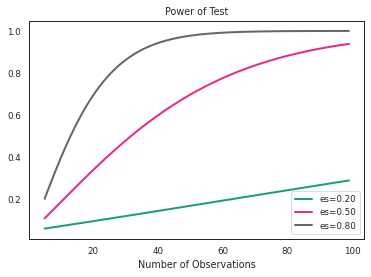

In [149]:
# Plot power curve
# See statistical power for a range of effect & sample sizes

# parameters for power analysis
effect_sizes = array([0.2, 0.5, 0.8])
sample_sizes = array(range(5, 100))
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes) 
plt.show()

So we can see from out hypothesis test there is an indication that radius_se  have significant differences between the benign and malignent groups. Furthermore, the effect size between the two groups for the normalised radius_se is high. This is confirmed by what we observe in the histograms above.

We can also see from our power analysis that we only need to have 50 observations to have high statisical power for our significance tests between the malignant and benign groups for the features.

Secondly, we can see some of the distributions are particularly skewed i.e. for features:

- radius_se
- perimeter_se
- area_se

These are going to be more difficult for the ML model to work with, so we will probably want to log-transform them to spread out their values more to make them of maximum use to our model.

Thirdly, we can see the units of the features and scale vary widely, with many such as 'symmetry_mean' being fractional decimals below 1, and others such as 'area_worst' has values ranging from a few hundred to over 3500. ML models are very sensitive to these differences of scale so to ensure our model treats all features equally, we will need to normalise them all so each feature is a value between 0 and 1.

Finally more generally we can see comapring the malignant v benign sub-groups accross all features, we can see there are some features where there is clearly much overlap between the groups, and other features where there is a big difference between the values for each groups - so both areas of commonality and difference. 

Let us now move from a univariate perspective to combining multiple features to build up a bigger picture of the dataset.

## 6 Normalise numerical features before modelling

We also noticed earlier what differing scales of values each of the features has (which again can be problematic for ML models). This will be useful to do before our dimensonality techniques for further analysis, as well as for our predictive modelling later. Lets normalise the values for all features to be betweeen 0 and 1.

In [150]:
bcancer_clean_df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [151]:
# Initialize a scaler, then apply it to the features to normalise
scaler = MinMaxScaler() # default=(0, 1)

numerical_features = bcancer_clean_df.columns
numerical_features = numerical_features[1:]

bcancer_clean_df = pd.DataFrame(data = bcancer_clean_df)
bcancer_clean_df[numerical_features] = scaler.fit_transform(bcancer_clean_df[numerical_features])

bcancer_clean_df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,0.338222,0.323965,0.332935,0.216920,0.394785,0.260601,0.208058,0.243137,0.379605,0.270379,0.106345,0.189324,0.099376,0.062636,0.181119,0.174439,0.080540,0.223454,0.178143,0.100193,0.296663,0.363998,0.283138,0.170906,0.404138,0.220212,0.217403,0.393836,0.263307,0.189596
std,0.483918,0.166787,0.145453,0.167915,0.149274,0.126967,0.161992,0.186785,0.192857,0.138456,0.148702,0.100421,0.121917,0.095267,0.084967,0.102067,0.134498,0.076227,0.116884,0.116316,0.091417,0.171940,0.163813,0.167352,0.139932,0.150779,0.152649,0.166633,0.225884,0.121954,0.118466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.223342,0.218465,0.216847,0.117413,0.304595,0.139685,0.069260,0.100944,0.282323,0.163016,0.043781,0.104690,0.040004,0.020635,0.117483,0.081323,0.038106,0.144686,0.102409,0.046750,0.180719,0.241471,0.167837,0.081130,0.300007,0.116337,0.091454,0.223127,0.185098,0.107700
50%,0.000000,0.302381,0.308759,0.293345,0.172895,0.390358,0.224679,0.144189,0.166501,0.369697,0.243892,0.077023,0.165267,0.072092,0.033112,0.158650,0.136675,0.065379,0.207047,0.152643,0.079191,0.250445,0.356876,0.235320,0.123206,0.397081,0.179110,0.181070,0.343402,0.247782,0.163977
75%,1.000000,0.416442,0.408860,0.416765,0.271135,0.475490,0.340531,0.306232,0.367793,0.453030,0.340354,0.133044,0.246155,0.122509,0.071700,0.218683,0.226800,0.106187,0.278651,0.219480,0.126556,0.386339,0.471748,0.373475,0.220901,0.494156,0.302520,0.305831,0.554639,0.318155,0.242949
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 7 Dimensionality reduction analysis 

### 7.1 Using t-SNE to compare cancer sub-groups

[t-SNE](https://www.datacamp.com/community/tutorials/introduction-t-sne) is a recent dimensionality reduction technique that can be used to compress a multi-dimensional dataset into fewer dimensions while aiming to retain the maximum variance of the original dimensions. 

It is a more recent dimensionality reduction technique, say compared to [PCA](https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2) that has various differences that I will not go into here, but are explored further in an earlier project of mine [here](https://github.com/pranath/high_dim_data_vis).

We will use t-SNE on this dataset to reduce the dimensionality to 2 dimensions, and then plot these on scatterplots dividing the data into malignant & benign sub-groups, to see how the values between these sub-groups compare, and see if we can get a better overall picture of how similar or different these sub-groups are.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 0.215072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.284069
[t-SNE] KL divergence after 300 iterations: 0.894506
t-SNE done! Time elapsed: 1.2689051628112793 seconds


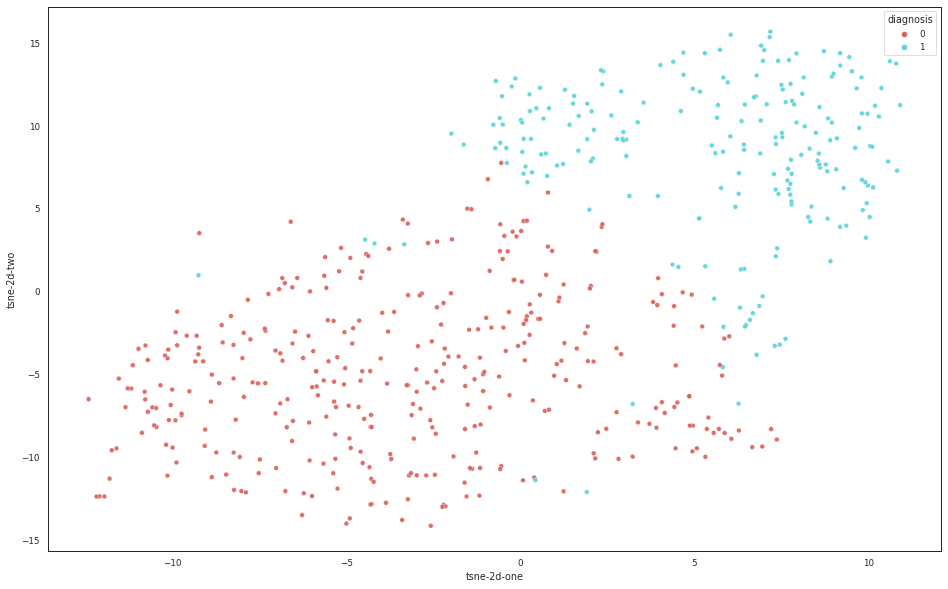

In [152]:
# Create 2 components using t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
features = bcancer_clean_df.drop('diagnosis', 1)
tsne_results = tsne.fit_transform(features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Plot dataset with 2 t-SNE features, using same colour for data for benign v malignent tumors
bcancer_clean_df['tsne-2d-one'] = tsne_results[:,0]
bcancer_clean_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="diagnosis",
    palette=sns.color_palette("hls", 2),
    data=bcancer_clean_df,
    legend="full",
    alpha=0.9
)

So we can observe various characteristics of the dataset and the subgroups.

We can see that there are clear areas for the benign and malignant groups only, but also common areas of overlap between the two groups.

These indicate the potential for a model using the dataset to be able to distinguish between the benign and malignant groups/cases.

### 7.2 Using UMAP to compare cancer sub-groups

While t-sne has various advantages over the 100 year old PCA technique, it does have its own disadvantages. These include:

- T-sne does not scale well for performance with increasing dataset sizes
- T-sne does not preseve global structure and relationships well
- T-sne can consume large amounts of memory when executing

[UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) is a dimensionality technique that aims to [improve upon these weaknesses](https://medium.com/@dan.allison/dimensionality-reduction-with-umap-b081837354dd) of t-sne. Read more about how UMAP works [here](https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668).

We will now apply UMAP to render both a 2D and a 3D representation of our cancer dataset.

In [153]:
# Separate feature columns
features = bcancer_clean_df.drop('diagnosis', 1)

# Initialise 2D & 3D UMAP models
umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

# Fit 2D & 3D UMAP models to our cancer data
proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)

# Use plotly to plot our projections
fig_2d = px.scatter(
    proj_2d, x=0, y=1, 
    color=bcancer_clean_df.diagnosis, labels={'color': 'diagnosis'}
)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=bcancer_clean_df.diagnosis, labels={'color': 'diagnosis'}
)
# Configure projections
fig_3d.update_traces(marker_size=5)
# Hide axes colouring for 3D
fig_3d.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig_2d.update_layout(
    autosize=False,
    width=800,
    height=800)
fig_3d.update_layout(
    autosize=False,
    width=800,
    height=800)
# Render projections
fig_2d.show()
fig_3d.show()

![title](img/umap1.png)

![title](img/umap2.png)

The UMAP 2D projection suggests a clearer separation between the cancer and non-cancer groups. The 3D projection also shows a clear separation, but also with a clearer morphology of each group as a shape.

## 8 Prepare data for ML model

### 8.1 Log transform skewed features

We identified earier some features that seem particularly skewed (which can be problematic for ML models). Lets log-transform these to try and even their distributions out.

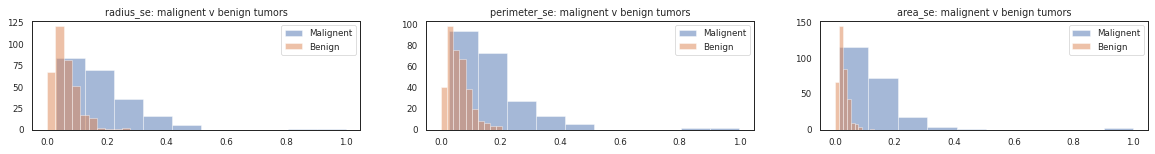

In [154]:
# Skewed features
skewed = ['radius_se', 'perimeter_se', 'area_se']

# Split dataset into those with malignent and those with benign tumors
malignent_df = bcancer_clean_df[bcancer_clean_df['diagnosis']==1]
benign_df = bcancer_clean_df[bcancer_clean_df['diagnosis']==0]

# Display the distributions of skewed features
compare_features_benign_malignent(skewed, malignent_df, benign_df, 1, 3, 20, 2)

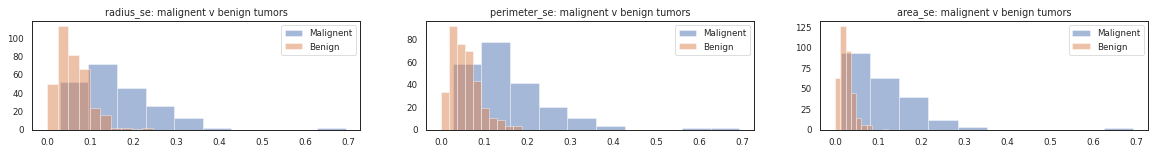

In [155]:
# Log transform Skewed features
features_log_transformed = pd.DataFrame(data = bcancer_clean_df)
features_log_transformed[skewed] = features_log_transformed[skewed].apply(lambda x: np.log(x + 1))

# Split dataset into those with malignent and those with benign tumors
malignent_log_transformed_df = features_log_transformed[features_log_transformed['diagnosis']==1]
benign_log_transformed_df = features_log_transformed[features_log_transformed['diagnosis']==0]

# Display the distributions of previously skewed features
compare_features_benign_malignent(skewed, malignent_log_transformed_df, benign_log_transformed_df, 1, 3, 20, 2)

Ok the log transform seems to have improved these distributions.

## 9 Metrics and naive predictor

In this section we will define our measure of success for our models and also define a naive predictor to act as a baseline measure.

So in this project, what is most important? we are going to define the key priority as being diagnosing those cases that actually have a malignant tumor most accurately. Of course, as a secondary priority - we do also want to minimise the number of cases where the tumor is actually benign, but we predict it to be malignant.

To get a measure of how well our models are doing for both of these at the same time, we can use the F1 score. We will also calculate an accuarcy score, although the F1 score will be the most important measure. The F1 score is also a good measure to use for our relatively small dataset (570 rows only).

We also want to establish some kind of benchmark to judge our models against, a baseline that we hope to do much better than with our sophisticated ML models! A common baseline is to define a 'naive' predictor - in this case that would be a predictor that classifies all tumors as malignant.

We will now define a naive predictor and calculate an F1 and accuracy score for it - this will be our baseline model and score that we will judge all our other models against.

In [156]:
# Naive predictor
'''
TP = np.sum(features_log_minmax_transform['diagnosis']) # Counting the ones as this is the naive case. 
FP = features_log_minmax_transform['diagnosis'].count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
accuracy = np.sum(features_log_minmax_transform['diagnosis']) / features_log_minmax_transform.shape[0]
recall = 1
precision = accuracy

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta_squared = 0.5 * 0.5
fscore = (1 + beta_squared) * ((precision * recall) / ((beta_squared * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3726, F-score: 0.4260]


## 10 ML model selection & development

For this problem - I have judged the following features are appropriate & desirable in guiding the selection of a machine learning model.

## 10.1 Model criteria

- **Memory & speed:** not primarily important but for what is feasible to be run within a notebook in a reasonable time, the aim is assumed to be a one off run of the model to predict rather than a model run continously where significant computational resources might be more an issue. 
- **Not overfitting:** I would regard this as desirable/important, we want a model that generalises well, its going to be run most likely periodically if used and we want to maximise the predictive power each time its run.
- **Time for learning/fitting:** like memory & speed, not so important beyond that which is reasonable to be run in the notebook without the browser timing out!
- **Time for predicting:** again like time for learning/fitting, not so important beyond what can be done in the notebook/browser. However, if we want to deploy and it's useful, we may want to run it on bigger datsets of patient data - so it is a factor worth taking into account.
- **Parameterisation:** slightly important. We will be using grid search later to optimise our solution, this will multiply the computational requirements used for a single model. Given the limit of our computatioal resources available in the notebook/browser a more simple parameterisation would allow the model to scale & deliver within this limited environment for a grid search.
- **Feature tolerance:** not so important, we have just under 40 features and there is no indication these will grow.

With these in mind, these are my selected models, their features - and the rationale for choosing them.

**Model 1 - LogisticRegression**

- **Strengths of model:** Fast to train, no parameter tuning, features don't need scaling, more tolerant to correlated features, excellent for 2-class classification problems
- **Weaknesses of model:** Not so good for large number of features, not good with non-linear decision boundries, not flexible enough to capture more complex relationships, adversely effected by features not relevent to output variable
- **Why model is a good candidate for this problem:** 1. The problem is a binary classification one, logistic regression is one of the best & simplest models for this kind of problem - worth considering occams razor! 2. The computational resources required for this model are low and ensure I can be certain this model will have no problem running in the notebook/browser on this dataset! I would like at least one of my models to be likely to run well with given computational resources. 

**Model 2 - GradientBoostingClassifier**

- **Strengths of model:** Can handle big datasets, very accurate, can approximate most non-linear classification boundries, one of best boosting models for many classification problems
- **Weaknesses of model:** Slow to train (concern over available resources in notebook/browser sufficient?), prone to overfitting, not easy to understand, sensitive to outliers & noisy data, parameterisation can make a real difference to performance - therefore could be more work/fiddly to optimise & get best results.
- **Why model is a good candidate for this problem:** 1. This model is one of the most popular (getting some of the best results) models for classification problems - worth serious consideration! 2. Paramaterisation can make a real difference to performance with this model, good chance of improvement in optimisation/grid search phase for one of the best solutions (assuming computational resources of notebook/browser sufficient).


**Model 3 - XGBoost**

- **Strengths of model:** Can handle big datasets, very accurate, can approximate most non-linear classification boundries, the best boosting model for many classification problems (best in class), faster than Gradient Boosting.
- **Weaknesses of model:** Prone to overfitting, not easy to understand, sensitive to outliers & noisy data, parameterisation can make a real difference to performance - therefore could be more work/fiddly to optimise & get best results.
- **Why model is a good candidate for this problem:** 1. This model is one of the most popular (getting some of the best results) models for classification problems - worth serious consideration! 2. Paramaterisation can make a real difference to performance with this model, good chance of improvement in optimisation/grid search phase for one of the best solutions (assuming computational resources of notebook/browser sufficient).

References

I found the following tables & cheatsheets particularly useful in selecting my models:

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

https://blogs.sas.com/content/subconsciousmusings/2017/04/12/machine-learning-algorithm-use/

https://www.dataschool.io/comparing-supervised-learning-algorithms/

https://recast.ai/blog/machine-learning-algorithms/2/

We will now split our dataset into training and testing subsets, and develop functions that will act as a training & testing pipleline, as well as displaying the results from all our models.

In [157]:
# Split data into train & test
X = features_log_minmax_transform[numerical_features]
y = features_log_minmax_transform['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)                                                                                                                                                                                              

In [158]:
# Define function that will act as pipeline for training and testing our models (and returning the results)
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time.time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time.time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time.time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time.time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [159]:
# Define function that will take the results of our model training & testing and plot the results
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.

    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """

    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (13,9))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["10%", "50%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")

    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")

    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()


In [160]:
# Initialize the three models
clf_A = linear_model.LogisticRegression()
clf_B = GradientBoostingClassifier()
clf_C = XGBClassifier()

# Calculate the number of samples for 10%, 50% and 100% of the training data
samples_100 = len(y_train)
samples_50 = int((samples_100 / 100) * 50)
samples_10 = int((samples_100 / 100) * 10)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_10, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 45 samples.
LogisticRegression trained on 227 samples.
LogisticRegression trained on 455 samples.
GradientBoostingClassifier trained on 45 samples.
GradientBoostingClassifier trained on 227 samples.
GradientBoostingClassifier trained on 455 samples.
XGBClassifier trained on 45 samples.
XGBClassifier trained on 227 samples.
XGBClassifier trained on 455 samples.


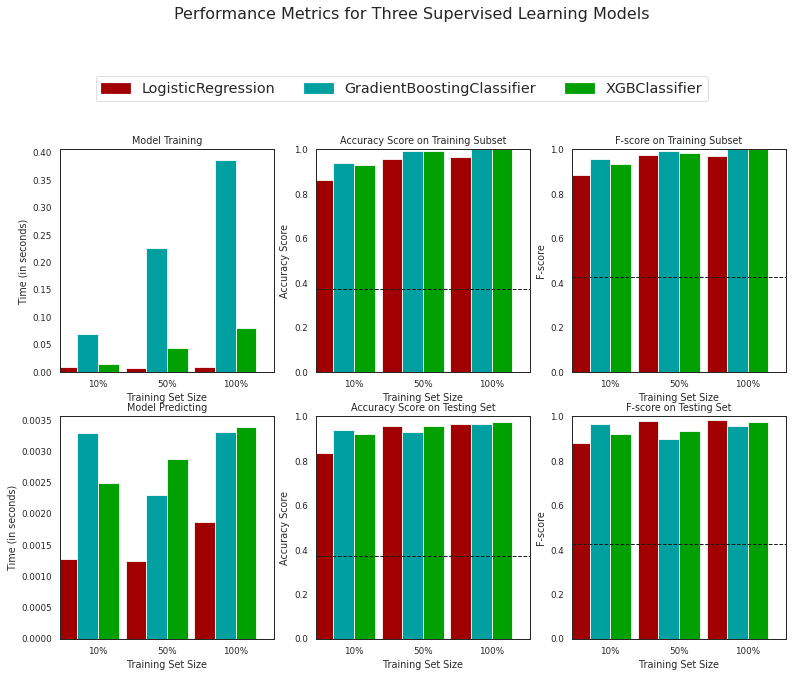

In [161]:
# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

We can observe the results of our model training and evaluation in the above plots of the metric scores for each model type.

Firstly we can see that all 3 models have done quite well, with all models getting at least 0.80 on the testing dataset, even when only 10% or 50% of that testing set was used.

For the model training, we can see that the GradientBoostingClassifier took by far the most time to train, and in terms of speed of predicting unsurprisingly LogisticRegression was the fastest. However, in terms of the key metric using 100% of the test dataset, we can see that the XGBoost seems to perform the best, and trains much faster than normal gradient boosting.

Therefore we will select the XGBoost as our best model and the one we want to optimise going forward.

### 10.2 Model cross-validation and tuning

We could of course simply split our data into training and test sets, train and optimise our model on the training data, and then get a final performance score on the test set to estimate how well the model will do on new data. However this is not a very rigerous methodology, it only gives us one single estimate of the model performance on the test data, and there is a danger of overfitting our model on our training data. To improve on this, we can employ two techniques, nested and repeated cross validation.

With [nested cross validation](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/) we can separate out the model optimisation process from the cross validation process of the data. This can give us a less biased estimation of how our optmised model will perform on new data and which hyper-parameters might be best.

With [repeated cross validation](https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/), we don't just run a cross validation procedure of k-folds once, but multiple times where on each run, the folds are randomised. Again, this can give us a less biased estimation of how our model will perform on new data.

We will now perform nested cross validation of the model using these 2 techniques together, to get a better estimate of how the model might perform on new data, as well as helping us to optimise the best model hyper-parameters using a cross-validated grid search.

In [162]:
# Configure outer cross-validation procedure
# (Used on whole dataset, splits into training & test set folds)
# (Also perform repeated k-fold to get better estimate of model performance)
# (Repeated k-fold will perform kfold x n_repeats times, randomising folds each time)
cv_outer = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
# Initialise vars to store results
outer_results_accuracy = list()
outer_results_f1 = list()
best_result = None

# For each outer loop train and test folds
for train_ix, test_ix in cv_outer.split(X):
  # Split whole dataset into current train and test folds
  X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
  y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
  # Configure inner cross-validation procedure
  # (For model training, splits train into train-train and train-validation folds)
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
  # Define the model
  model = XGBClassifier(random_state=1)
  # Define grid search space
  space = dict()
  space['n_estimators'] = [10, 50, 300]
  space['max_depth'] = [2,3,5]
  # Define metrics
  scoring = {'F1': make_scorer(fbeta_score, beta=0.5, average='macro'), 'Accuracy': make_scorer(accuracy_score)}
  # Define cv grid search for model on training set
  # (Once search over, take best model and refit on whole training set using F1)
  search = GridSearchCV(model, space, scoring=scoring, cv=cv_inner, refit='F1')
  # Execute grid search
  result = search.fit(X_train, y_train)
  # Get the best performing model (refit on the whole training set)
  best_model_train = result.best_estimator_
  # Generate model predictions on the outer loop test set (never seen by model)
  yhat = best_model_train.predict(X_test)
  # Evaluate model predictions on the outer loop test set 
  acc = accuracy_score(y_test, yhat)
  f1 = fbeta_score(y_test, yhat,beta=0.5)
  # Store the results
  outer_results_accuracy.append(acc)
  outer_results_f1.append(f1)
  # Save model if its the best so far
  if best_result == None:
    best_result = result
  else:
    if best_result.best_score_ < result.best_score_:
      best_result = result
  # Report progress
  print('>acc=%.3f, >f1=%.3f, est=%.3f, cfg=%s' % (acc, f1, result.best_score_, result.best_params_))
# Summarize the estimated performance of the model
print('Mean Accuracy: %.3f (%.3f), Mean F1: %.3f (%.3f)' % (mean(outer_results_accuracy), std(outer_results_accuracy), mean(outer_results_f1), std(outer_results_f1)))
  

>acc=0.982, >f1=0.991, est=0.951, cfg={'max_depth': 5, 'n_estimators': 300}
>acc=0.947, >f1=0.964, est=0.963, cfg={'max_depth': 2, 'n_estimators': 300}
>acc=0.930, >f1=0.885, est=0.962, cfg={'max_depth': 2, 'n_estimators': 300}
>acc=0.982, >f1=0.955, est=0.952, cfg={'max_depth': 2, 'n_estimators': 300}
>acc=0.965, >f1=0.981, est=0.976, cfg={'max_depth': 5, 'n_estimators': 300}
>acc=0.982, >f1=0.968, est=0.965, cfg={'max_depth': 2, 'n_estimators': 300}
>acc=0.965, >f1=0.981, est=0.966, cfg={'max_depth': 2, 'n_estimators': 300}
>acc=0.982, >f1=0.955, est=0.970, cfg={'max_depth': 5, 'n_estimators': 300}
>acc=0.982, >f1=0.991, est=0.971, cfg={'max_depth': 5, 'n_estimators': 300}
>acc=0.964, >f1=0.980, est=0.967, cfg={'max_depth': 5, 'n_estimators': 300}
>acc=0.982, >f1=0.991, est=0.963, cfg={'max_depth': 3, 'n_estimators': 300}
>acc=0.982, >f1=0.990, est=0.960, cfg={'max_depth': 5, 'n_estimators': 50}
>acc=0.947, >f1=0.937, est=0.953, cfg={'max_depth': 2, 'n_estimators': 300}
>acc=0.912, >

Our nested cross validation procedure has given us 100 measures of model performance (both F1 and accuracy). 

#### 10.2.1 Plot distributions of F1 & accuracy scores for cross validation

Lets plot the distributions and means for F1 and accuracy scores.

Text(0, 0.5, 'Count')

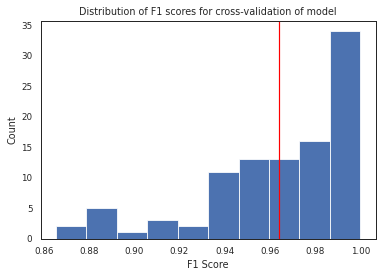

In [163]:
# Plot distribution of model F1 scores
plt.hist(outer_results_f1)
# Also plot the mean
mean_f1 = mean(outer_results_f1)
plt.axvline(x=mean_f1, color = 'red');
plt.title('Distribution of F1 scores for cross-validation of model')
plt.xlabel('F1 Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

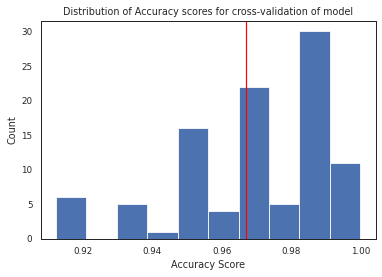

In [164]:
# Plot distribution of model accuracy scores
plt.hist(outer_results_accuracy)
# Also plot the mean
mean_accuracy = mean(outer_results_accuracy)
plt.axvline(x=mean_accuracy, color = 'red');
plt.title('Distribution of Accuracy scores for cross-validation of model')
plt.xlabel('Accuracy Score')
plt.ylabel('Count')

We know the mean accuracy and F1 scores for our cross validated models is around 0.96, and we can see the distributions of the values in each case. We can use these to better estimate the actual performance on the model on new data, by using these to build confidence intervals for both scores.

#### 10.2.2 Build confidence intervals for mean F1 & accuracy scores 


50th percentile (median) = 0.963
2.5th percentile = 0.959
97.5th percentile = 0.970
 


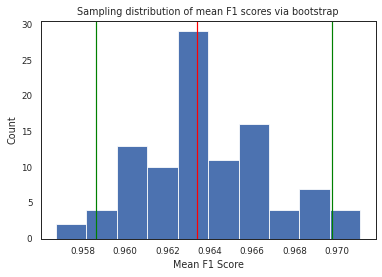

In [165]:
# Build confidence interval for mean F1 score using bootstrap sampling distribution 
# (Non-parametric - assumes no distribution of mean F1 score)
# seed the random number generator
seed(1)
# Convert list into array
outer_results_f1 = np.array(outer_results_f1)

# bootstrap
scores = list()
for _ in range(100):
	# bootstrap sample (with replacement)
	indices = randint(0, 100, 100)
	sample = outer_results_f1[indices]
	# calculate and store statistic
	statistic = mean(sample)
	scores.append(statistic)

print('50th percentile (median) = %.3f' % median(scores))
# calculate 95% confidence intervals (100 - alpha)
alpha = 5.0
# calculate lower percentile (e.g. 2.5)
lower_p = alpha / 2.0
# retrieve observation at lower percentile
lower = max(0.0, percentile(scores, lower_p))
print('%.1fth percentile = %.3f' % (lower_p, lower))
# calculate upper percentile (e.g. 97.5)
upper_p = (100 - alpha) + (alpha / 2.0)
# retrieve observation at upper percentile
upper = min(1.0, percentile(scores, upper_p))
print('%.1fth percentile = %.3f' % (upper_p, upper))
print(' ')

plt.title('Sampling distribution of mean F1 scores via bootstrap')
plt.xlabel('Mean F1 Score')
plt.ylabel('Count')
plt.hist(scores)
plt.axvline(x=median(scores), color = 'red')
plt.axvline(x=upper, color = 'green')
plt.axvline(x=lower, color = 'green')

50th percentile (median) = 0.967
2.5th percentile = 0.963
97.5th percentile = 0.971
 


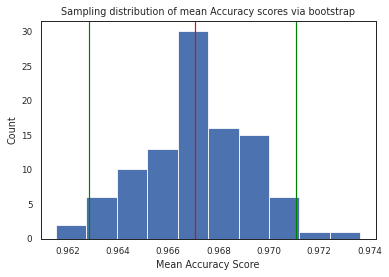

In [166]:
# Build confidence interval for mean accuracy score using bootstrap sampling distribution 
# (Non-parametric - assumes no distribution of mean accuracy score)
# seed the random number generator
seed(1)
# Convert list into array
outer_results_accuracy = np.array(outer_results_accuracy)

# bootstrap
scores = list()
for _ in range(100):
	# bootstrap sample (with replacement)
	indices = randint(0, 100, 100)
	sample = outer_results_accuracy[indices]
	# calculate and store statistic
	statistic = mean(sample)
	scores.append(statistic)

print('50th percentile (median) = %.3f' % median(scores))
# calculate 95% confidence intervals (100 - alpha)
alpha = 5.0
# calculate lower percentile (e.g. 2.5)
lower_p = alpha / 2.0
# retrieve observation at lower percentile
lower = max(0.0, percentile(scores, lower_p))
print('%.1fth percentile = %.3f' % (lower_p, lower))
# calculate upper percentile (e.g. 97.5)
upper_p = (100 - alpha) + (alpha / 2.0)
# retrieve observation at upper percentile
upper = min(1.0, percentile(scores, upper_p))
print('%.1fth percentile = %.3f' % (upper_p, upper))
print(' ')

plt.title('Sampling distribution of mean Accuracy scores via bootstrap')
plt.xlabel('Mean Accuracy Score')
plt.ylabel('Count')
plt.hist(scores)
plt.axvline(x=median(scores), color = 'red')
plt.axvline(x=upper, color = 'green')
plt.axvline(x=lower, color = 'green')

## 11 ML model evaluation

Below is a summary table of the key results from developing our ML model.

| Metric | Benchmark Model | Optimized Model |
| --- | --- | --- | 
| Accuracy Score | 0.3726 | 0.9670 |
| F-score | 0.4260 | 0.9630 |

We will take the F1 score as the better indicator of model performance. We can then say, as a result of our cross-validation procedure, that we estimate the model F1 score performance to be 0.96, within a range of 0.95-0.97 with a 95% confidence level.

Let us now examine the model to see which features it found most useful for prediction.

## 12 Feature importance

We will now define a function to extract and plot the top most useful features for the model.

In [167]:
def feature_plot(importances, X_train, y_train):

    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)

    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

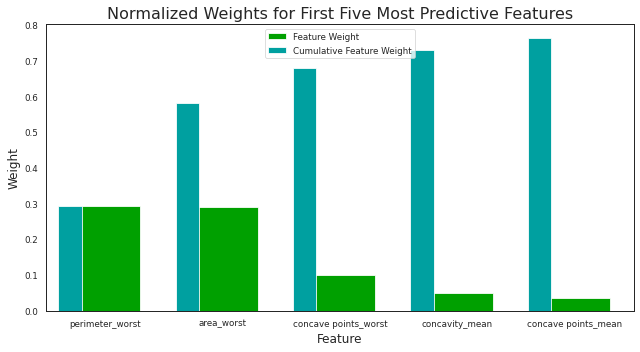

In [168]:
# Extract the feature importances 
importances = best_result.best_estimator_.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

We can see from the extracted feature importances that the top 3 features used by the model are:

- perimeter worst
- area_worst
- concave points_worst

Interestingly, these were features we highlighted earlier in the univariate analysis as features that had a very different distribution of values for the malignant and benign tumor sub-groups.

## 13 Conclusion

In this project we have looked at a dataset relating to breast cancer, and have 
developed a model able to predict malignant tumors with a very high degree of accuracy (an F-score of 0.963).

We have also gained an understanding of the reasons why our model is able to predict this well. Our earlier analysis showed the difference in morphology beween cell metrics for malignant v benign tumors, which could be seen visually in the images and were expressed in different distributions of values for particular feature measurements of the cells that we observed.

Our use of higher level analytical tools such as UMAP also allowed us to gain a much better understanding of the dataset, in particular a better idea of the range of feature values that were typical for malignant and benign tumors as 'groups' within the dataset.